In [13]:
#https://medium.com/towards-formula-1-analysis/how-to-recreate-the-formula-1-aws-corner-analysis-in-python-37c26363c47b

In [1]:
import numpy as np
import pandas as pd

import fastf1 as ff1
from fastf1 import plotting

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Enable the cache
ff1.Cache.enable_cache('cache') 

In [3]:
# Load the session data
quali = ff1.get_session(2021, 'British GP', 'Q')

# Get the laps
laps = quali.load_laps(with_telemetry=True)

/opt/anaconda3/lib/python3.9/site-packages/fastf1/core.py:1127: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for British Grand Prix - Qualifying [v2.2.8]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_stat

In [4]:
# Setting parameters
driver_1, driver_2 = 'HAM', 'VER'

distance_min, distance_max = 4800, 5500 

In [5]:
# Extracting the laps
laps_driver_1 = laps.pick_driver(driver_1)
laps_driver_2 = laps.pick_driver(driver_2)

telemetry_driver_1 = laps_driver_1.pick_fastest().get_car_data().add_distance()
telemetry_driver_2 = laps_driver_2.pick_fastest().get_car_data().add_distance()

# Identifying the team for coloring later on
team_driver_1 = laps_driver_1.reset_index().loc[0, 'Team']
team_driver_2 = laps_driver_2.reset_index().loc[0, 'Team']

In [6]:
# Assigning labels to what the drivers are currently doing 
telemetry_driver_1.loc[telemetry_driver_1['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_1.loc[telemetry_driver_1['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_1.loc[(telemetry_driver_1['Brake'] == 0) & (telemetry_driver_1['Throttle'] < 100), 'CurrentAction'] = 'Cornering'

telemetry_driver_2.loc[telemetry_driver_2['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_2.loc[telemetry_driver_2['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_2.loc[(telemetry_driver_2['Brake'] == 0) & (telemetry_driver_2['Throttle'] < 100), 'CurrentAction'] = 'Cornering'


In [7]:
# Numbering each unique action to identify changes, so that we can group later on
telemetry_driver_1['ActionID'] = (telemetry_driver_1['CurrentAction'] != telemetry_driver_1['CurrentAction'].shift(1)).cumsum()
telemetry_driver_2['ActionID'] = (telemetry_driver_2['CurrentAction'] != telemetry_driver_2['CurrentAction'].shift(1)).cumsum()


In [8]:
# Identifying all unique actions
actions_driver_1 = telemetry_driver_1[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()
actions_driver_2 = telemetry_driver_2[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()

actions_driver_1['Driver'] = driver_1
actions_driver_2['Driver'] = driver_2

In [9]:
# Calculating the distance between each action, so that we know how long the bar should be
actions_driver_1['DistanceDelta'] = actions_driver_1['Distance'] - actions_driver_1['Distance'].shift(1)
actions_driver_1.loc[0, 'DistanceDelta'] = actions_driver_1.loc[0, 'Distance']

actions_driver_2['DistanceDelta'] = actions_driver_2['Distance'] - actions_driver_2['Distance'].shift(1)
actions_driver_2.loc[0, 'DistanceDelta'] = actions_driver_2.loc[0, 'Distance']

In [10]:
# Merging together
all_actions = actions_driver_1.append(actions_driver_2)

/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_57908/4026539744.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_actions = actions_driver_1.append(actions_driver_2)


In [11]:
# Calculating average speed
avg_speed_driver_1 = np.mean(telemetry_driver_1['Speed'].loc[
    (telemetry_driver_1['Distance'] >= distance_min) & 
        (telemetry_driver_1['Distance'] >= distance_max) 
])


avg_speed_driver_2 = np.mean(telemetry_driver_2['Speed'].loc[
    (telemetry_driver_2['Distance'] >= distance_min) & 
        (telemetry_driver_2['Distance'] >= distance_max) 
])

if avg_speed_driver_1 > avg_speed_driver_2:    
    speed_text = f"{driver_1} {round(avg_speed_driver_1 - avg_speed_driver_2,2)}km/h faster"
else:
    speed_text = f"{driver_1} {round(avg_speed_driver_2 - avg_speed_driver_1,2)}km/h faster"


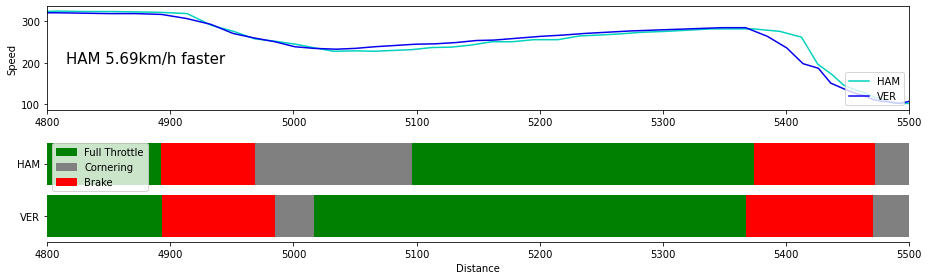

In [12]:
##############################
#
# Setting everything up
#
##############################
plt.rcParams["figure.figsize"] = [13, 4]
plt.rcParams["figure.autolayout"] = True

telemetry_colors = {
    'Full Throttle': 'green',
    'Cornering': 'grey',
    'Brake': 'red',
}

fig, ax = plt.subplots(2)


##############################
#
# Lineplot for speed 
#
##############################
ax[0].plot(telemetry_driver_1['Distance'], telemetry_driver_1['Speed'], label=driver_1, color=ff1.plotting.team_color(team_driver_1))
ax[0].plot(telemetry_driver_2['Distance'], telemetry_driver_2['Speed'], label=driver_2, color=ff1.plotting.team_color(team_driver_2))

# Speed difference
ax[0].text(distance_min + 15,200, speed_text, fontsize = 15)

ax[0].set(ylabel='Speed')
ax[0].legend(loc="lower right")


##############################
#
# Horizontal barplot for telemetry
#
##############################
for driver in [driver_1, driver_2]:
    driver_actions = all_actions.loc[all_actions['Driver'] == driver]
    
    previous_action_end = 0
    for _, action in driver_actions.iterrows():
        ax[1].barh(
            [driver], 
            action['DistanceDelta'], 
            left=previous_action_end, 
            color=telemetry_colors[action['CurrentAction']]
        )
        
        previous_action_end = previous_action_end + action['DistanceDelta']
        
        
##############################
#
# Styling of the plot
#
##############################   
# Set x-label
plt.xlabel('Distance')

# Invert y-axis 
plt.gca().invert_yaxis()

# Remove frame from plot
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

# Add legend
labels = list(telemetry_colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=telemetry_colors[label]) for label in labels]
ax[1].legend(handles, labels)

# Zoom in on the specific part we want to see
ax[0].set_xlim(distance_min, distance_max)
ax[1].set_xlim(distance_min, distance_max)

# Save the plot
plt.savefig('2021_Silverstone_Q_HAM_vs_VER_Corner_Analysis.png', dpi=300)
